<a href="https://colab.research.google.com/github/baljash-cheema/The-Hungry-Hornets/blob/main/cp4_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Graph Analytics Demo**
**Using Spark GraphX**



---


# **Spark and GraphFrames Set Up**


In [1]:
# install java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.2.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment. 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.0-bin-hadoop3.2"

# install findspark using pip
!pip install -q findspark

# install pyspark
!pip3 install pyspark==3.2.0

# install graphframes
!pip3 install graphframes

     |████████████████████████████████| 281.3 MB 8.2 kB/s 
     |████████████████████████████████| 198 kB 31.6 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=228ec7f12ecca848718b224238b9fcdb053d59cf9f0262bba227134e6e3b796e
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark
     |████████████████████████████████| 154 kB 31.7 MB/s 


Download the graphframes jar file from: [Graphframe jar file:](https://repos.spark-packages.org/graphframes/graphframes/0.8.2-spark3.2-s_2.12/graphframes-0.8.2-spark3.2-s_2.12.jar)

Upload it in the Google Colab Files folder. Can be found in the left pane of this window.

In [2]:
!cp -v /content/graphframes-0.8.2-spark3.2-s_2.12.jar $SPARK_HOME/jars/

'/content/graphframes-0.8.2-spark3.2-s_2.12.jar' -> '/content/spark-3.2.0-bin-hadoop3.2/jars/graphframes-0.8.2-spark3.2-s_2.12.jar'


In [3]:
#import the packages
from pyspark import *
from pyspark.sql import *
from graphframes import *
import findspark
import pandas as pd

findspark.init()

# Start a Spark session
spark = SparkSession.builder.master("local[*]").getOrCreate()



---
# **This notebook covers the following:**


---


1.  **GraphFrames Basic Functionalities**


*   Create GraphFrames
*   Calculate inDegrees, outDegrees, degrees
* Generate Subgraphs
* Motif Finding
2.  **Built-In Algorithms**

*   Connected Components
*   PageRank
*   Triangle Count
*   Label Propagation

3. **CPDB Example**

* Connect to the CPDB database
* Create a graph from SQL tables
* Graph Analytics 


# **GraphX Basic Functionalities**

**Create Graphframes from vertices and edges Dataframe**

In [ ]:
vertices = spark.createDataFrame([
  ("a", "Alice", 34),
  ("b", "Bob", 36),
  ("c", "Charlie", 30),
  ("d", "David", 29),
  ("e", "Esther", 32),
  ("f", "Fanny", 36),
  ("g", "Gabby", 60)], ["id", "name", "age"])

In [ ]:
edges = spark.createDataFrame([
  ("a", "b", "friend"),
  ("b", "c", "follow"),
  ("c", "b", "follow"),
  ("f", "c", "follow"),
  ("e", "f", "follow"),
  ("e", "d", "friend"),
  ("d", "a", "friend"),
  ("a", "e", "friend")
], ["src", "dst", "relationship"])

In [ ]:
g = GraphFrame(vertices, edges)

In [ ]:
g.vertices.show()

+---+-------+---+
| id|   name|age|
+---+-------+---+
|  a|  Alice| 34|
|  b|    Bob| 36|
|  c|Charlie| 30|
|  d|  David| 29|
|  e| Esther| 32|
|  f|  Fanny| 36|
|  g|  Gabby| 60|
+---+-------+---+



In [ ]:
g.edges.show()

+---+---+------------+
|src|dst|relationship|
+---+---+------------+
|  a|  b|      friend|
|  b|  c|      follow|
|  c|  b|      follow|
|  f|  c|      follow|
|  e|  f|      follow|
|  e|  d|      friend|
|  d|  a|      friend|
|  a|  e|      friend|
+---+---+------------+



In [ ]:
g.vertices.count()

7

In [ ]:
g.edges.count()

8

In [ ]:
# NetworkX to visualize the graph
import networkx as nx

def plot_graph(gx):
    g = nx.DiGraph(directed = True)
    
    g = nx.from_pandas_edgelist(gx.edges.toPandas(),'src','dst')
    g.add_nodes_from(gx.vertices.toPandas()['id'])

    nx.draw(g, with_labels=True, arrows = True, node_color='grey')

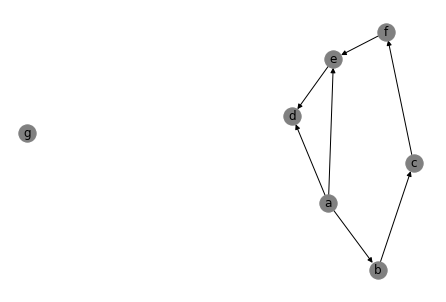

In [ ]:
plot_graph(g)




**inDegrees** is the number of edges directed into a vertex in a directed graph

Usecase: We can identify those vertices/nodes that are highly connected by using the sort function

In [ ]:
g.inDegrees.sort(['inDegree'],ascending=[0]).show()

+---+--------+
| id|inDegree|
+---+--------+
|  b|       2|
|  c|       2|
|  f|       1|
|  e|       1|
|  a|       1|
|  d|       1|
+---+--------+



**outDegrees** is the number of edges directed out of a vertex in a directed graph

In [ ]:
g.outDegrees.sort(['outDegree'],ascending=[0]).show()

+---+---------+
| id|outDegree|
+---+---------+
|  e|        2|
|  a|        2|
|  f|        1|
|  c|        1|
|  d|        1|
|  b|        1|
+---+---------+



**Degree** is just the number of edges connected to a node regardless of the direction of an edge

In [ ]:
g.degrees.sort(['Degree'],ascending=[0]).show()

+---+------+
| id|degree|
+---+------+
|  c|     3|
|  e|     3|
|  b|     3|
|  a|     3|
|  f|     2|
|  d|     2|
+---+------+



**Create Subgraphs**

In [ ]:
g1 = g.filterVertices("age > 20").filterEdges("relationship = 'friend'").dropIsolatedVertices()
g1.edges.show()

+---+---+------------+
|src|dst|relationship|
+---+---+------------+
|  d|  a|      friend|
|  a|  b|      friend|
|  e|  d|      friend|
|  a|  e|      friend|
+---+---+------------+



In [ ]:
# Select subgraph based on edges "e" of type "follow"
# pointing from a younger user "a" to an older user "b".
paths = g.find("(a)-[e]->(b)")\
  .filter("e.relationship = 'follow'")\
  .filter("a.age < b.age")

# "paths" contains vertex info. Extract the edges.
e2 = paths.select("e.src", "e.dst", "e.relationship")


# Construct the subgraph
g2 = GraphFrame(g.vertices, e2)
g2.edges.show()

+---+---+------------+
|src|dst|relationship|
+---+---+------------+
|  c|  b|      follow|
|  e|  f|      follow|
+---+---+------------+



**Motif Finding**

Used for searching for structural patterns in a graph. 


Eg. `"(a)-[e]->(b); (b)-[e2]->(c)"` specifies all the transitive relationships between a and c



In [ ]:
# Search for pairs of vertices with edges in both directions between them.
motifs = g.find("(a)-[e]->(b); (b)-[e2]->(a)")
motifs.show()

+----------------+--------------+----------------+--------------+
|               a|             e|               b|            e2|
+----------------+--------------+----------------+--------------+
|{c, Charlie, 30}|{c, b, follow}|    {b, Bob, 36}|{b, c, follow}|
|    {b, Bob, 36}|{b, c, follow}|{c, Charlie, 30}|{c, b, follow}|
+----------------+--------------+----------------+--------------+



In [ ]:
# More complex queries can be expressed by applying filters.
motifs.filter("b.age > 30").show()

+----------------+--------------+------------+--------------+
|               a|             e|           b|            e2|
+----------------+--------------+------------+--------------+
|{c, Charlie, 30}|{c, b, follow}|{b, Bob, 36}|{b, c, follow}|
+----------------+--------------+------------+--------------+



# **Built-In Algorithms**


---



**PageRank Algorithm**:

In [ ]:
pr = g.pageRank(resetProbability=0.15, tol=0.01)
## look at the pagerank score for every vertex
pr.vertices.show()
## look at the weight of every edge
pr.edges.show()

+---+-------+---+-------------------+
| id|   name|age|           pagerank|
+---+-------+---+-------------------+
|  g|  Gabby| 60| 0.1799821386239711|
|  f|  Fanny| 36| 0.3283606792049851|
|  e| Esther| 32|0.37085233187676075|
|  d|  David| 29| 0.3283606792049851|
|  c|Charlie| 30| 2.6878300011606218|
|  b|    Bob| 36|  2.655507832863289|
|  a|  Alice| 34|0.44910633706538744|
+---+-------+---+-------------------+

+---+---+------------+------+
|src|dst|relationship|weight|
+---+---+------------+------+
|  f|  c|      follow|   1.0|
|  e|  f|      follow|   0.5|
|  e|  d|      friend|   0.5|
|  d|  a|      friend|   1.0|
|  c|  b|      follow|   1.0|
|  b|  c|      follow|   1.0|
|  a|  e|      friend|   0.5|
|  a|  b|      friend|   0.5|
+---+---+------------+------+



**Connected Components**

In [ ]:
from pyspark.context import SparkContext
sc = SparkContext.getOrCreate(SparkConf())
sc.setCheckpointDir('/content/sample_data')
# SparkContext.setCheckpointDir(dirName= '/content/sample_data')


In [ ]:
g.connectedComponents().show()

+---+-------+---+------------+
| id|   name|age|   component|
+---+-------+---+------------+
|  a|  Alice| 34|412316860416|
|  b|    Bob| 36|412316860416|
|  c|Charlie| 30|412316860416|
|  d|  David| 29|412316860416|
|  e| Esther| 32|412316860416|
|  f|  Fanny| 36|412316860416|
|  g|  Gabby| 60|146028888064|
+---+-------+---+------------+



**Label Propagation**


In [ ]:
communities = g.labelPropagation(maxIter=40)
communities.persist().show(10)
print (f"There are {communities.select('label').distinct().count()} communities in this sample graph.")

+---+-------+---+-------------+
| id|   name|age|        label|
+---+-------+---+-------------+
|  g|  Gabby| 60| 146028888064|
|  b|    Bob| 36|1382979469312|
|  e| Esther| 32|1047972020224|
|  a|  Alice| 34|1460288880640|
|  f|  Fanny| 36|1460288880640|
|  d|  David| 29|1382979469312|
|  c|Charlie| 30|1047972020224|
+---+-------+---+-------------+

There are 4 communities in this sample graph.


In [ ]:
#only shows the top 5 rows
labelp_result.groupby('label').count().sort('count', ascending=False).show(5)

+-------------+-----+
|        label|count|
+-------------+-----+
|1382979469312|    2|
|1047972020224|    2|
|1460288880640|    2|
| 146028888064|    1|
+-------------+-----+



**Triangle Count**

In [ ]:
tc_friends = g.triangleCount()
tc_friends.select("id", "count").show()

+---+-----+
| id|count|
+---+-----+
|  c|    0|
|  b|    0|
|  a|    1|
|  g|    0|
|  f|    0|
|  e|    1|
|  d|    1|
+---+-----+



# **CPDB Example**

Analyze the police officers connection with allegations

In [6]:
import psycopg2

In [7]:
# access the postgresql server
conn = psycopg2.connect(
    host="codd04.research.northwestern.edu",
    port = "5433",
    database="postgres",
    user="cpdbstudent",
    password="DataSci4AI")

In [8]:
cursor = conn.cursor()

**Following query creates nodes and edges to answer the questions.**



*   **nodes**: id, officer name and allegation count
*   **edges**: src(officer1 id), dist(officer2 id) and relationship(allegation count)

In [34]:
edges_query = "DROP TABLE IF EXISTS award_count;CREATE TEMP TABLE award_count AS (SELECT officer_id offid, count(award_type) num_awards FROM data_award WHERE data_award.officer_id IN (SELECT id FROM data_officer WHERE data_officer.id IN (SELECT officer_id FROM data_officerallegation WHERE data_officerallegation.allegation_category_id IN (SELECT id FROM data_allegationcategory WHERE data_allegationcategory.category = 'Drug / Alcohol Abuse' OR data_allegationcategory.category = 'Medical' or allegation_name LIKE 'Medical Roll%' OR data_allegationcategory.category_code IN ('024', '003', '003A', '003B', '003C', '003D', '003E')))) group by officer_id); DROP TABLE IF EXISTS da_category_ids;CREATE TEMP TABLE da_category_ids AS (SELECT id FROM data_allegationcategory WHERE data_allegationcategory.category = 'Drug / Alcohol Abuse' OR data_allegationcategory.category = 'Medical' or allegation_name LIKE 'Medical Roll%' OR data_allegationcategory.category_code IN ('08J', '024', '003', '003A', '003B', '003C', '003D', '003E')); DROP TABLE IF EXISTS da_cohort; CREATE TEMP TABLE da_cohort AS (SELECT DISTINCT officer_id FROM data_officerallegation WHERE allegation_category_id IN (SELECT * from da_category_ids)); DELETE FROM da_cohort c USING award_count a WHERE a.offid = c.officer_id AND a.num_awards > (SELECT AVG(num_awards) FROM award_count); DROP TABLE IF EXISTS class_example; CREATE TEMP TABLE class_example AS (SELECT da1.officer_id src, da2.officer_id dst, COUNT(DISTINCT da1.allegation_id) relationship FROM data_officerallegation da1 JOIN data_officerallegation da2 ON da1.allegation_id = da2.allegation_id AND da1.officer_id < da2.officer_id GROUP BY da1.officer_id, da2.officer_id ORDER BY count(*) DESC); SELECT src,dst,relationship FROM class_example JOIN da_cohort ON da_cohort.officer_id = class_example.src;"


In [35]:
nodes_query = "SELECT  id, first_name || ' ' || last_name officer_name, allegation_count FROM data_officer;"

In [36]:
cursor.execute(edges_query)
edges = cursor.fetchall()
print("shape is: " + str(len(edges))) # 17465

df_edges = pd.DataFrame(edges)
colnames = [desc[0] for desc in cursor.description]
df_edges.columns = colnames

print(df_edges.shape)

shape is: 17399
(17399, 3)


In [37]:
cursor.execute(nodes_query)
nodes = cursor.fetchall()
print("shape is: " + str(len(nodes))) # 17465

df_nodes = pd.DataFrame(nodes)
colnames = [desc[0] for desc in cursor.description]
df_nodes.columns = colnames

print(df_nodes.shape)

shape is: 35545
(35545, 3)


In [38]:
edges_ = spark.createDataFrame(df_edges)

In [39]:
nodes = spark.createDataFrame(df_nodes)

In [40]:
cpdb = GraphFrame(nodes, edges_)

In [41]:
cpdb.vertices.show()

+-----+---------------+----------------+
|   id|   officer_name|allegation_count|
+-----+---------------+----------------+
|32312|   Randall Ryan|            10.0|
|32358|    Kevin Stoll|            24.0|
|32480|    David Lavin|             0.0|
|32491|     Kevin Rake|             0.0|
| 2680| Richard Brandt|             0.0|
|29553| Hugh Versteegh|             0.0|
|19974|  Andrew Murcia|             0.0|
| 8259|    Hugh Farmer|             0.0|
|17716|Anthony Matassa|             0.0|
|19659|  John Moriarty|             0.0|
|32506|Richard Francis|             0.0|
|29111|   Robert Tyson|             0.0|
| 1791|  Chas Bennette|             0.0|
|17146|  Robert Malone|             0.0|
|17242|  Jerry Manning|             0.0|
|17289|Michael Maratto|             0.0|
|32467|  Jonathan Boyd|             0.0|
|33755|Phyllis Butcher|             1.0|
|  333|Leroy Alexander|             0.0|
|18597|  James Mcglynn|             0.0|
+-----+---------------+----------------+
only showing top

In [42]:
cpdb.edges.show()

+---+-----+------------+
|src|  dst|relationship|
+---+-----+------------+
|  9|12641|           1|
| 17|26456|           2|
| 17|10656|           2|
| 17|22523|           1|
| 17|20246|           1|
| 17|15351|           1|
| 17|12521|           1|
| 17| 9373|           1|
| 17| 6885|           1|
| 17| 4494|           1|
| 17|32102|           1|
| 17|28925|           1|
| 17|27976|           1|
| 54|27802|           1|
| 54|29189|           1|
| 54|30398|           1|
| 54|31550|           1|
| 54|31756|           1|
| 54| 4168|           1|
| 54|11252|           1|
+---+-----+------------+
only showing top 20 rows



In [43]:
cpdb.vertices.sort(['id'],ascending=True).show()

+---+-----------------+----------------+
| id|     officer_name|allegation_count|
+---+-----------------+----------------+
|  1|    Jeffery Aaron|             6.0|
|  2|     Karina Aaron|             8.0|
|  3|     Daniel Abate|             0.0|
|  4|    Carmel Abbate|             7.0|
|  5|    Carmen Abbate|             4.0|
|  6|   Anthony Abbate|             6.0|
|  7|     Terry Abbate|             8.0|
|  8|       Leon Abbey|             2.0|
|  9|    Michael Abbey|             3.0|
| 10|       Leon Abbey|             0.0|
| 11|     Laura Abbott|             7.0|
| 12|    Andrew Abbott|             7.0|
| 13|      Dale Abbott|            10.0|
| 14| Elizabeth Abbott|             4.0|
| 15|    Zaid Abdallah|             1.0|
| 16| Aziz Abdelmajeid|            19.0|
| 17|  Moulay Abdullah|            25.0|
| 18|    Jason Abejero|             5.0|
| 19|Restituto Abejero|             5.0|
| 20|    Kenneth Abels|             3.0|
+---+-----------------+----------------+
only showing top

**Implement Graph Algorithms**

In [44]:
tc_cpdb = cpdb.triangleCount()
tc_cpdb.select("id", "count").show()

+-----+-----+
|   id|count|
+-----+-----+
|19659|    0|
| 8259|    0|
|33755|    0|
|17716|    0|
|33725|    0|
|32506|    0|
|17146|    0|
|  333|    0|
|17289|    0|
| 2680|    0|
|19974|    0|
|17242|    0|
|32491|    0|
|32312|    0|
|32358|    0|
|32480|    0|
| 1791|    0|
|18597|    0|
|29553|    0|
|29111|    0|
+-----+-----+
only showing top 20 rows



In [45]:
pr_cpdb = cpdb.pageRank(resetProbability=0.15, tol=0.01)
#look at the pagerank score for every vertex
pr_cpdb.vertices.orderBy('pagerank', ascending=False).show()

+-----+-----------------+----------------+------------------+
|   id|     officer_name|allegation_count|          pagerank|
+-----+-----------------+----------------+------------------+
|29955|     Carl Walston|             1.0| 9.488189209095959|
|23005|       Paul Price|             1.0|5.1287509238356535|
|32032|    Brian Hawkins|            49.0| 3.822971898485041|
|29035|     Edward Tures|            14.0| 3.688170394356435|
|32405|     Henry Walton|            16.0|3.6798633702465344|
|32198|  Raphael Mitchem|            52.0|3.6581260248766743|
|22480|   Edwin Phillips|             1.0| 3.616765984304687|
|31265|      Lee Wozniak|            12.0| 3.567876759496298|
|31906|      James Davis|            76.0| 2.921448705344427|
|31115|  Andrew Wojnicki|             3.0|2.8977680812447795|
|31497|        John Zago|             7.0| 2.854126755117965|
|19154|    Raymond Mills|             1.0|2.8217626334384858|
|32314|     Jose Salazar|            43.0|  2.73908208998554|
|29088| 

**Message Passing using aggregateMessages()**

In [46]:
from pyspark.sql.functions import sum as sqlsum
from graphframes.lib import AggregateMessages as AM
# from graphframes.examples import Graphs
# g = Graphs(sqlContext).friends()  # Get example graph

# For each user, sum the ages of the adjacent users.
msgToSrc = AM.dst["allegation_count"]
msgToDst = AM.src["allegation_count"]
agg = cpdb.aggregateMessages(
    sqlsum(AM.msg).alias("summedAllegations"),
    sendToSrc=msgToSrc,
    sendToDst=msgToDst)

agg.sort(['id'],ascending=True).show()

+---+-----------------+
| id|summedAllegations|
+---+-----------------+
|  9|             13.0|
| 17|            208.0|
| 54|            309.0|
| 59|            123.0|
|117|            163.0|
|156|            738.0|
|160|            208.0|
|197|             74.0|
|198|            556.0|
|200|           3734.0|
|223|             86.0|
|237|            416.0|
|241|             16.0|
|325|             77.0|
|335|             11.0|
|361|            460.0|
|364|             32.0|
|368|             16.0|
|381|             16.0|
|396|             14.0|
+---+-----------------+
only showing top 20 rows

